In [1]:
import geopandas
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eust
import intersection
import settings
import nuts
import fadn
import plots

# Load NUTS regions GIS data

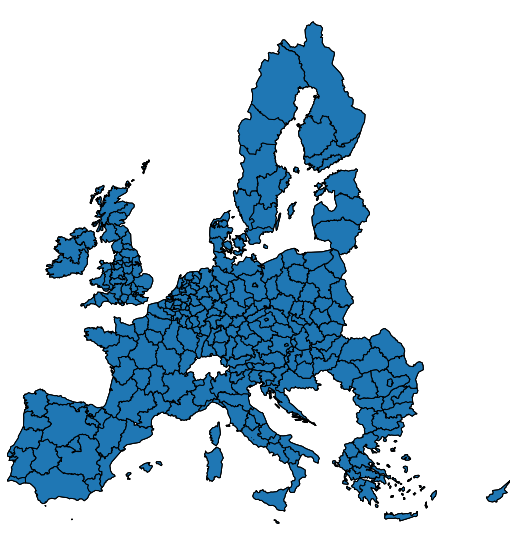

In [2]:
nuts_table = nuts.get_nuts_candidates()
candidate_nuts_regions = nuts_table.index
nuts_geo = (
    geopandas
    .read_file(settings.NUTS_GIS_PATH)
    .set_index('NUTS_ID')
    .reindex(candidate_nuts_regions)
)
ax = nuts_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN regions

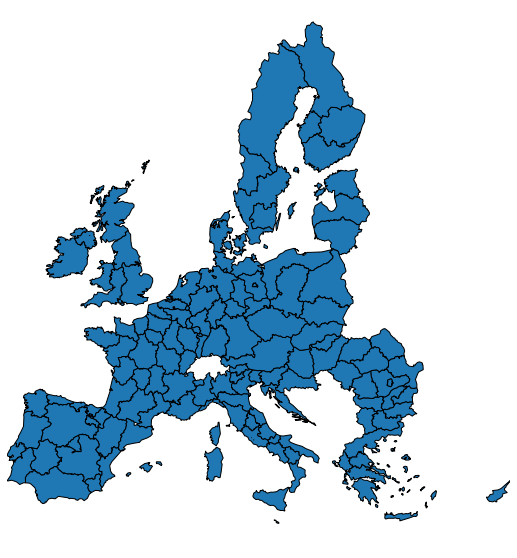

In [3]:
fadn_geo = (
    geopandas
    .read_file(settings.FADN_GIS_PATH)
    .set_index('FADN_2012_')
    [["geometry"]]
)
ax = fadn_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN data

In [4]:
fadn_data = fadn.read_fadn_data('YEAR.COUNTRY.REGION')
fadn_data

SYS02  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             23150   
                                 343         Wallonie               12380   
     CYP          Cyprus         740         Cyprus                 14270   
     CZE          Czech Republic 745         Czech Republic         15930   
     DAN          Denmark        370         Denmark                33850   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  21680   
                                 413         England - West Region  20700   
                                 421         Wales                  10140   
                                 431         Scotland               13140   
                                 441         Northern Ireland       14880   

                                                                           SYS03  \
year country_code country_name   region_code region_name                           
2004 BEL          Belgium        341         Vlaanderen              500 - <1000   
                                 343         Wallonie                500 - <1000   
     CYP          Cyprus         740         Cyprus                   200 - <500   
     CZE          Czech Republic 745         Czech Republic         1000 - <2000   
     DAN          Denmark        370         Denmark                1000 - <2000   
...                                                                          ...   
2017 UKI          United Kingdom 412         England - East Region   500 - <1000   
                                 413         England - West Region   500 - <1000   
                                 421         Wales                    200 - <500   
                                 431         Scotland                 200 - <500   
                                 441         Northern Ireland         200 - <500   

                                                                       SYS04  \
year country_code country_name   region_code region_name                       
2004 BEL          Belgium        341         Vlaanderen             40.33990   
                                 343         Wallonie               40.33990   
     CYP          Cyprus         740         Cyprus                  0.58192   
     CZE          Czech Republic 745         Czech Republic         31.90567   
     DAN          Denmark        370         Denmark                 7.43990   
...                                                                      ...   
2017 UKI          United Kingdom 412         England - East Region   0.88200   
                                 413         England - West Region   0.88200   
                                 421         Wales                   0.88200   
                                 431         Scotland                0.88200   
                                 441         Northern Ireland        0.88200   

                                                                    SE005  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             206.4   
                                 343         Wallonie               155.1   
     CYP          Cyprus         740         Cyprus                  47.1   
     CZE          Czech Republic 745         Czech Republic         232.3   
     DAN          Denmark        370         Denmark                204.0   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  329.2   
                                 413         England - West Region  226.7   
                                 421         Wales                  133.6   
                                 431         Scotland               171.7   
        

## Calculate and plot P fertilizer rates for whole UAA

In [5]:
# SE297 = total P2O5 use on farm [100 kg]
# SE025 = total UAA on farm [ha]
fadn_p_qty = (
    fadn_data['SE297']
    .mul(100)  # to kg P2O5
    .mul(31 * 2 / (31 * 2 + 16 * 5)) # to kg P
)
fadn_rates_all = (
    fadn_p_qty
    .div(fadn_data['SE025'])
    .rename('rate')
)
fadn_rates_all

year  country_code  country_name    region_code  region_name          
2004  BEL           Belgium         341          Vlaanderen                    NaN
                                    343          Wallonie                      NaN
      CYP           Cyprus          740          Cyprus                        NaN
      CZE           Czech Republic  745          Czech Republic                NaN
      DAN           Denmark         370          Denmark                       NaN
                                                                            ...   
2017  UKI           United Kingdom  412          England - East Region    9.762165
                                    413          England - West Region    5.664991
                                    421          Wales                    4.819064
                                    431          Scotland                 5.487220
                                    441          Northern Ireland         3.097915
Name: rate, Leng

In [6]:
# Check which years have P rates at all
fadn_rates_all.dropna().index.unique('year')

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='year')

In [7]:
RATE_PLOT_V_KWS = dict(vmin=0, vmax=30)
def plot_p_rate(d, ax=None, legend=True):
    ax = (
        nuts_geo
        .plot(color='#cccccc', ax=ax)
        .axes
    )
    d.plot(
        'rate',
        cmap='BuPu',
        legend=legend,
        ax=ax,
        **RATE_PLOT_V_KWS
    ).axes
    plots.adj_geoplot(ax)
    return ax

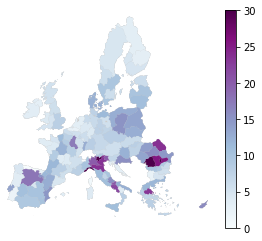

In [8]:
# Take the average value
fadn_rate = fadn_rates_all.groupby('region_code').mean().dropna()
ax = fadn_geo.join(fadn_rate).dropna().pipe(plot_p_rate)

# Load Eurostat area and P rate data

In [9]:
uaa = (
    eust
    .read_table_data('ef_lus_allcrops')
    .value
    .xs('HA', level='unit')
    .xs('UAA', level='crops')
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
    .pipe(nuts.fill_nuts)
)
uaa

geo
AT      2726890.0
AT1     1098840.0
AT11     181970.0
AT12     908850.0
AT13       8020.0
          ...    
UKM3     798340.0
UKM5     478770.0
UKM6    2763560.0
UKN     1046140.0
UKN0    1046140.0
Name: value, Length: 428, dtype: float64

## Extract all national and subnational P application data

In [10]:
eurostat_p_qty_all = (
    eust
    .read_table_data('aei_fm_usefert')
    .value
    .xs('P', level='nutrient')
    .xs('T', level='unit')
    .mul(1e3) # to kg
    .pipe(nuts.fill_nuts)
)
eurostat_p_qty_all

geo  time
AL   2000    35018000.0
     2001    34586000.0
     2002    36887000.0
     2003    35127000.0
     2004    36907000.0
                ...    
UK   2014    88228000.0
     2015    85555000.0
     2016    85989000.0
     2017    86425000.0
     2018           NaN
Name: value, Length: 4317, dtype: float64

## Note that the coverage of subnational data is maximal in the chosen data year

So we do not lose anything by extracting data only from the chosen data year.

In [11]:
data_for_chosen_year = (
    eurostat_p_qty_all
    .xs(settings.DATA_YEAR, level='time')
    .reindex(candidate_nuts_regions)
    .dropna()
)

mean_value_all_years = (
    eurostat_p_qty_all
    .groupby('geo')
    .mean()
    .reindex(candidate_nuts_regions)
    .dropna()
)

set(data_for_chosen_year.index) == set(mean_value_all_years.index)

True

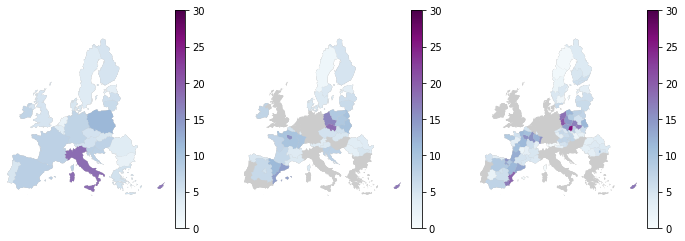

In [12]:
eurostat_p_qty = eurostat_p_qty_all.xs(settings.DATA_YEAR, level='time')
eurostat_rate = (
    eurostat_p_qty
    .div(uaa) # kg / ha
    .dropna()
    .rename('rate')
)

nuts_levels = [0, 1, 2]
fig, axs = plt.subplots(ncols=len(nuts_levels), figsize=(4 * len(nuts_levels), 4))

for ax, level in zip(axs, nuts_levels):
    (
        nuts_geo
        .join(nuts_table)
        .join(eurostat_rate)
        .loc[lambda d: d.nuts_level == level]
        [['rate', 'geometry']]
        .dropna()
        .pipe(plot_p_rate, ax=ax)
    )
    plots.adj_geoplot(ax)

# Calculate share of each FADN region in each NUTS region

In [13]:
fadn_shares = intersection.get_share(fadn_geo, nuts_geo)
fadn_shares

FADN_2012_  geo 
10          DE      4.304178e-02
            DE6     1.395809e-05
            DE60    1.395809e-05
            DE8     3.571632e-07
            DE80    3.571632e-07
                        ...     
862         HU3     1.554515e-09
            HU33    4.196940e-09
            SI      1.141321e-06
            SI0     1.141321e-06
            SI01    1.903670e-06
Name: share, Length: 1669, dtype: float64

In [14]:
# Sanity check: shares should add up to about 100% in each region
fadn_shares.groupby("geo").sum().describe()

count    394.000000
mean       0.998824
std        0.010235
min        0.861934
25%        0.999997
50%        0.999999
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [15]:
# FADN zone coverage is evidently not 100% everywhere,
# but it is good in almost all the NUTS regions we use here
fadn_shares.groupby('geo').sum()[candidate_nuts_regions].describe()

count    394.000000
mean       0.998824
std        0.010235
min        0.861934
25%        0.999997
50%        0.999999
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [16]:
# Let's inspect the NUTS regions with bad coverage
bad_coverage = (
    fadn_shares
    .groupby('geo')
    .sum()
    [candidate_nuts_regions]
    .sort_values()
    .loc[lambda x: x < 0.95]
)
bad_coverage

geo
EL42    0.861934
FR      0.868241
NL      0.949589
Name: share, dtype: float64

## Check that the regions with bad coverage are no real problems

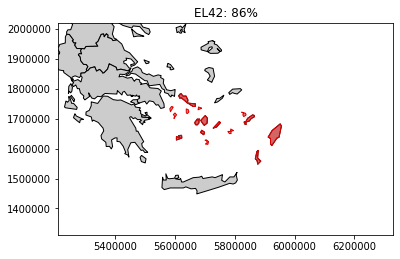

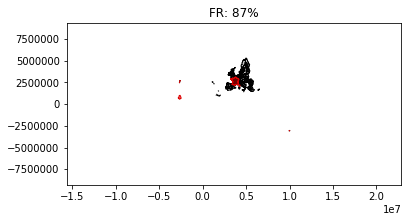

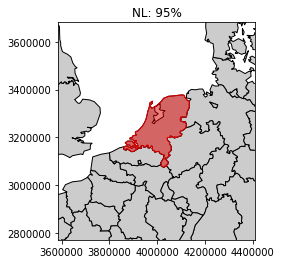

In [17]:
def plot_coverage_case(background, foreground, ax=None):
    ax = background.plot(color='#cccccc', edgecolor='k', ax=ax).axes
    foreground.plot(color='#dd000080', edgecolor='#dd0000', ax=ax)
    xmin, ymin, xmax, ymax = foreground.total_bounds
    dx = xmax - xmin
    dy = ymax - ymin
    ax.set_xlim(xmin-dx, xmax+dx)
    ax.set_ylim(ymin-dy, ymax+dy)
    return ax

for k, v in bad_coverage.items():
    ax = plot_coverage_case(fadn_geo, nuts_geo.loc[[k]])
    ax.set_title(f'{k}: {v:.0%}')

In [18]:
# To deal with the few NUTS regions that are poorly covered,
# calculate weights that by definition add up to 100% in each NUTS region.
# To avoid any mistakes, let's only include the NUTS regions used in this analysis.
fadn_weights = (
    fadn_shares
    .groupby('geo')
    .apply(lambda s: s / s.sum())
    .loc[:, candidate_nuts_regions]
)
fadn_weights.groupby('geo').sum().describe().round(5)

count    394.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share, dtype: float64

In [19]:
fadn_weights.to_csv(settings.FADN_WEIGHTS_PATH, header=True)

# Calculate FADN yield in NUTS regions using weights

In [20]:
fadn_rate_nuts = (
    fadn_rate
    .rename_axis('FADN_2012_')
    .mul(fadn_weights)
    .groupby('geo')
    .sum()
    .rename('rate')
)
fadn_rate_nuts

geo
AT      5.675903
AT1     5.675905
AT11    5.675928
AT12    5.675901
AT13    5.675897
          ...   
UKM3    5.436145
UKM5    5.436145
UKM6    5.436145
UKN     3.009187
UKN0    3.009187
Name: rate, Length: 394, dtype: float64

# Calculate FADN rates adjusted to agree with national totals

In [21]:
fadn_totals = (
    fadn_rate_nuts
    .mul(uaa)
    .rename('fadn_total')
    .dropna()
    .to_frame()
    .join(nuts_table[['nuts_level', 'country_code']])
    .groupby(['country_code', 'nuts_level'])
    .sum()
)
fadn_totals

fadn_total
country_code nuts_level              
AT           0           1.547756e+07
             1           1.547756e+07
             2           1.547756e+07
BE           0           5.464788e+06
             1           5.388301e+06
...                               ...
SK           1           1.216134e+07
             2           1.216134e+07
UK           0           9.889826e+07
             1           9.735983e+07
             2           9.745220e+07

[84 rows x 1 columns]

In [22]:
totals = (
    fadn_totals
    .join(eurostat_p_qty.rename('eurostat_total'), on='country_code')
    .dropna()
)
totals

fadn_total  eurostat_total
country_code nuts_level                              
AT           0           1.547756e+07      14234000.0
             1           1.547756e+07      14234000.0
             2           1.547756e+07      14234000.0
BE           0           5.464788e+06       4682000.0
             1           5.388301e+06       4682000.0
...                               ...             ...
SK           1           1.216134e+07       8959000.0
             2           1.216134e+07       8959000.0
UK           0           9.889826e+07      84692000.0
             1           9.735983e+07      84692000.0
             2           9.745220e+07      84692000.0

[84 rows x 2 columns]

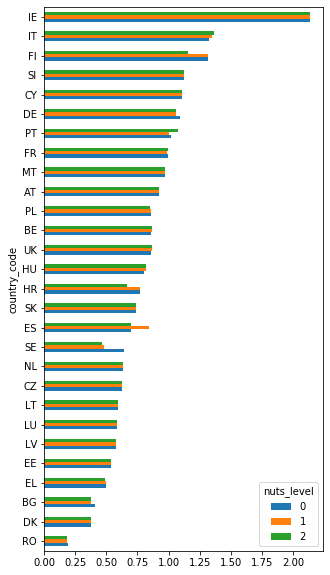

In [23]:
correction_factor = totals.eval('eurostat_total / fadn_total').rename('factor')
correction_factor.unstack('nuts_level').sort_values(0).plot.barh(figsize=(5, 10))

In [24]:
correction_factor

country_code  nuts_level
AT            0             0.919654
              1             0.919654
              2             0.919654
BE            0             0.856758
              1             0.868920
                              ...   
SK            1             0.736679
              2             0.736679
UK            0             0.856355
              1             0.869886
              2             0.869062
Name: factor, Length: 84, dtype: float64

In [25]:
fadn_rate_nuts_adj = (
    fadn_rate_nuts
    .to_frame()
    .join(nuts_table)
    .join(correction_factor, on=['country_code', 'nuts_level'], how='inner')
    .eval('rate * factor')
    .rename('rate')
)
fadn_rate_nuts_adj

geo
AT      5.219866
AT1     5.219868
AT2     5.219865
AT3     5.219865
AT11    5.219889
          ...   
UKM2    4.724347
UKM3    4.724347
UKM5    4.724347
UKM6    4.724347
UKN0    2.615170
Name: rate, Length: 394, dtype: float64

# Inspect the three datasets

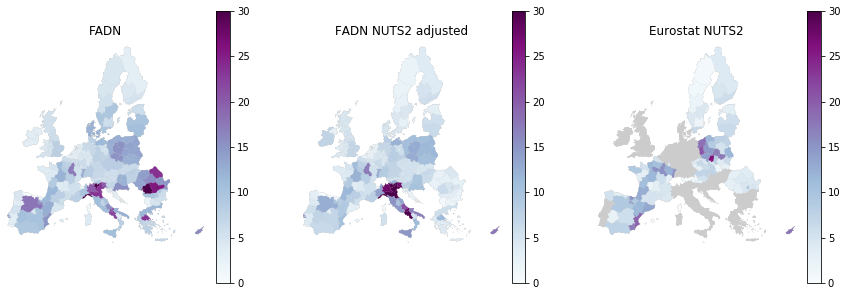

In [26]:
def get_nuts2(d):
    return d.reindex(nuts_table.loc[lambda d: d.nuts_level == 2].index).dropna()

data = {
    'FADN': fadn_rate_nuts,
    'FADN NUTS2 adjusted': fadn_rate_nuts_adj,
    'Eurostat NUTS2': eurostat_rate,
}

fig, axs = plt.subplots(ncols=len(data), figsize=(5*len(data), 5))

for (title, s), ax in zip(data.items(), axs):
    plot_p_rate(nuts_geo.join(get_nuts2(s), how='inner'), ax=ax)
    ax.set_title(title)

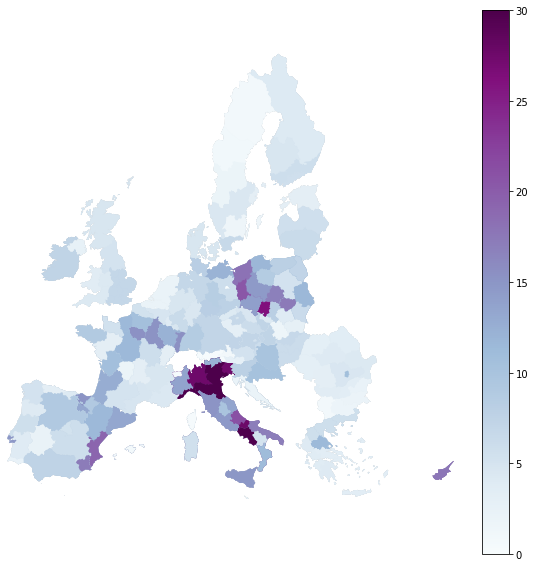

In [27]:
final_estimate = fadn_rate_nuts_adj.reindex(candidate_nuts_regions)
final_estimate.update(eurostat_rate)
ax = plot_p_rate(nuts_geo.join(final_estimate).dropna())
ax.figure.set_size_inches(10, 10)

In [28]:
final_estimate.to_csv(settings.MINERAL_P_RATE_PATH, header=True)